In [1]:
#unit variance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# a)

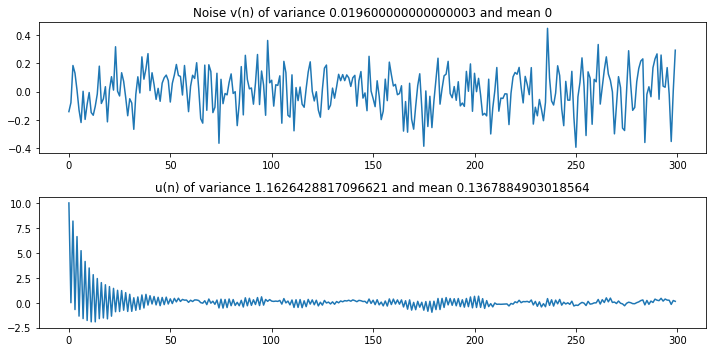

In [2]:
mean_v = 0
std_v = 0.14
N = 300
a1 = 0.1
a2 = -0.8
v = np.random.normal(mean_v, std_v, size=N)#noise
u = np.zeros(N)
u[0]=10
for i in range(2,N,1):
    u[i] = -a1*u[i-1]-a2*u[i-2]+v[i]#AR process
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(v)
plt.title('Noise v(n) of variance '+format(std_v**2)+' and mean 0')
plt.subplot(212)
plt.plot(u)
plt.title('u(n) of variance '+format(np.std(u)**2)+' and mean '+format(np.mean(u)))
plt.tight_layout()
plt.show()

# b)

There is no step size parameter. The adaptive weigh-control mechanism does not use that parameter for recalculating new tap weights

# c)

In [3]:
d = u #u now is gonna have 2 values each iteration, and the previous input u is going to be called d

In [4]:
w=np.zeros((N,2))#2 tap weights
#f=np.zeros(N)
#mu=0.05
I = np.array([[1,0],[0,1]])
lamda = 0.98
sigma = 100
P = (1/sigma)*I
#f[0]=u[0]
w[0][0]=0
w[0][1]=0
xi = np.zeros((N,2))
e1 = np.zeros(N)
e2 = np.zeros(N)

for i in range(1,N,1):
    u = np.array([d[i],d[i-1]])
    k = ((1/lamda)*np.dot(P,u))/(1+(1/lamda)*np.dot(np.dot(np.transpose(u),P),u))#gain vector
    xi[i] = d[i] - np.dot(np.transpose(w[i-1]), u)#a priori estimation error
    w[i] = w[i-1] + np.dot(k, np.transpose(xi[i]))#tap weights
    P = (1/lamda)*P - (1/lamda)*np.dot(np.dot(k,np.transpose(u)),P)#inverse correlation matrix
    #tap weight erros
    e1[i]=-a1-w[i][0]
    e2[i]=-a2-w[i][1]


# d)

100 MC runs over xi (a priori estimation error)

In [5]:
w=np.zeros((N,2))#2 tap weights
I = np.array([[1,0],[0,1]])
lamda = 0.5
sigma = 1000000
P = (1/sigma)*I
w[0][0]=0
w[0][1]=0
xi = np.zeros((N,2))
xiMC = np.zeros((100,300,2))
std_v = 0.14
a1 = 0.1
a2 = -0.8

for MC in range(100):
    v = np.random.normal(mean_v, std_v, size=N)#noise
    u = np.zeros(N)
    u[0]=10
    for i in range(2,N,1):
        u[i] = -a1*u[i-1]-a2*u[i-2]+v[i]#AR process
    d = u
    for i in range(1,N,1):
        u = np.array([d[i],d[i-1]])
        k = ((1/lamda)*np.dot(P,u))/(1+(1/lamda)*np.dot(np.dot(np.transpose(u),P),u))#gain vector
        xiMC[MC][i] = d[i] - np.dot(np.transpose(w[i-1]), u)#a priori estimation error
        w[i] = w[i-1] + np.dot(k, np.transpose(xiMC[MC][i]))#tap weights
        P = (1/lamda)*P - (1/lamda)*np.dot(np.dot(k,np.transpose(u)),P)#inverse correlation matrix
        

for j in range(N):
    for i in range(100):
        xi[j]+=xiMC[i][j]   
    xi[j]=xi[j]/100

# e)

It is expected from the learning curves that RLS filter converges in less samples (faster) as compared to LMS filter, reducing the training overhead considerably.

We can make a direct graphical comparison between the learning curves of the RLS and LMS algorithms. We therefore base a computation of the ensemble-average learning curve of the RLS algorithm on the a priori estimation error

In general, the RLS algorithm is more statistically efficient than the LMS algorithm when both algorithms operate in the same stationary environment.

This statement is intuitively satisfying for the following reason: In statistical terms, the RLS algorithm is a second-order estimator, whereas the LMS algorithm is a firstorder estimator.

### LMS and RLS 100 Monte Carlo simulations

We put them together in the same iteration so they have same stationary conditions

In [14]:
#100 Monte Carlo simulations
#LSM
N = 300
w=np.zeros((N+1,2))#2 tap weights
fMC=np.zeros((N,100))
f_=np.zeros(N)
mu=0.005

w[0][0]=0
w[0][1]=0
mean_v = 0
std_v = 0.14
a1 = 0.1
a2 = -0.8

#RLS
wr=np.zeros((N,2))#2 tap weights
I = np.array([[1,0],[0,1]])
lamda = 0.9
sigma = 100
P = (1/sigma)*I
wr[0][0]=0
wr[0][1]=0
xi = np.zeros((N,2))
xiMC = np.zeros((100,300,2))


for MC in range(100):
    v = np.random.normal(mean_v, std_v, size=N)#noise
    u = np.zeros(N)
    u[0]=10
    for i in range(2,N,1):
        u[i] = -a1*u[i-1]-a2*u[i-2]+v[i]#AR process
    d = u
    for i in range(N-1):
        fMC[i][MC]=u[i]-(np.dot(w[i][0],u[i-1])+np.dot(w[i][1],u[i-2]))#predictor error
        fMC[i][MC]=u[i]-(np.dot(w[i][0],u[i-1])+np.dot(w[i][1],u[i-2]))
        w[i+1][0]=w[i][0]+mu*u[i-1]*fMC[i][MC]#first tap weigh
        w[i+1][1]=w[i][1]+mu*u[i-2]*fMC[i][MC]#second tap weigh

        ur = np.array([d[i+1],d[i]])
        k = ((1/lamda)*np.dot(P,ur))/(1+(1/lamda)*np.dot(np.dot(np.transpose(ur),P),ur))
        xiMC[MC][i+1] = d[i+1] - np.dot(np.transpose(wr[i]), ur)
        wr[i+1] = wr[i] + np.dot(k, np.transpose(xiMC[MC][i+1]))
        P = (1/lamda)*P - (1/lamda)*np.dot(np.dot(k,np.transpose(ur)),P)

for i in range(N):
    for j in range(100):
        f_[i]+=fMC[i][j]   
        xi[i]+=xiMC[j][i]
    f_[i]=f_[i]/100
    xi[i]=xi[i]/100

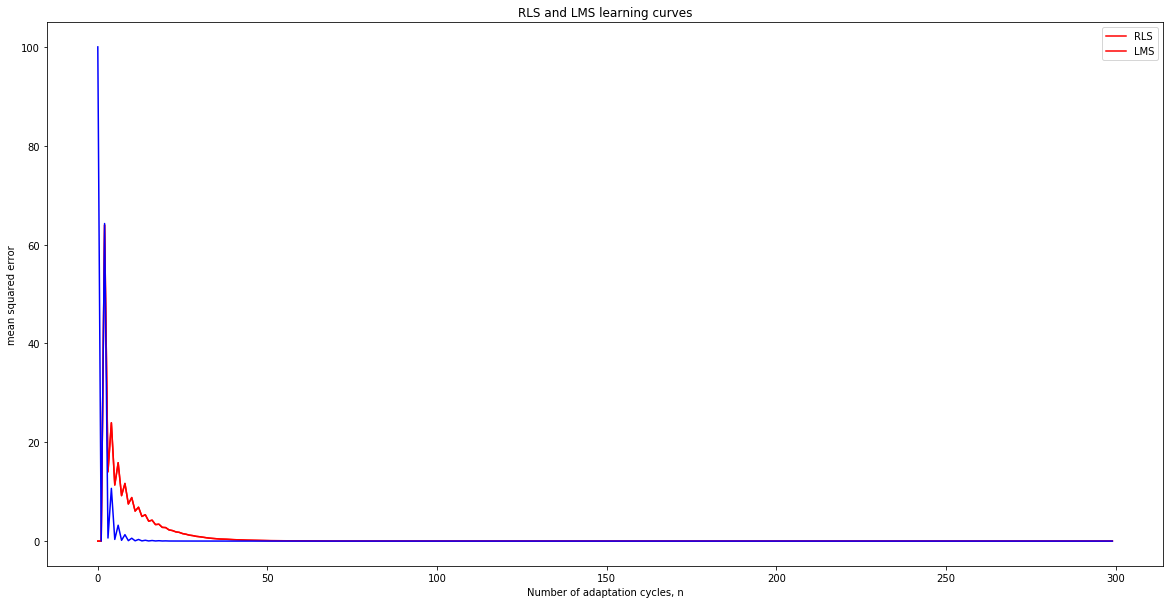

In [17]:
plt.figure(figsize=(20,10))
plt.plot(xi**2,'r',f_**2,'b')#learning curve, error xi vs number of adaptation cycles
plt.legend(('RLS','LMS'))
plt.xlabel('Number of adaptation cycles, n')
plt.ylabel('mean squared error')
plt.title('RLS and LMS learning curves')
plt.show()

RLS learning curve is the red line, LMS learning curve is the blue line. Contrary to what it was expected, LMS learning curve converges faster (in less cycles) than the RLS learning curve. Further study is needed to understand this behavior. 